In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import yaml
import pandas as pd
import zipfile

# Load the zip file
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/data602_project/t20s.zip', 'r')

# Create an empty DataFrame to store the data
data = pd.DataFrame(columns=['Match_id','Gender', 'Date', 'City','Venue', 'Team_1', 'Team_2', 'Toss_winner', 'Toss_decision', 'Winner','Win_By_Runs','Win_By_Wickets'])

# Iterate over each file in the zip file
for filename in zip_file.namelist():
    # Open each YAML file
    with zip_file.open(filename) as file:
        # Load the YAML data
        yaml_data = yaml.safe_load(file)

        # Check if yaml_data is a dictionary
        if isinstance(yaml_data, dict):
            # Check if 'info' and 'dates' keys exist in the dictionary
            if 'info' in yaml_data and 'dates' in yaml_data['info']:
                # Extract the required data
                match_id = os.path.splitext(filename)[0]
                gender = yaml_data['info'].get('gender', None)  # Use .get() method to avoid KeyError
                date = yaml_data['info']['dates'][0]
                city = yaml_data['info'].get('city', None)  # Use .get() method to avoid KeyError
                venue = yaml_data['info'].get('venue', None)  # Use .get() method to avoid KeyError
                team_1 = yaml_data['info']['teams'][0]
                team_2 = yaml_data['info']['teams'][1]
                toss_winner = yaml_data['info']['toss']['winner']
                toss_decision = yaml_data['info']['toss']['decision']
                winner = yaml_data['info']['outcome'].get('winner', None)  # Use .get() method to avoid KeyError
                if 'by' in yaml_data['info']['outcome']:
                    win_by_runs = yaml_data['info']['outcome']['by'].get('runs', None)
                    win_by_wickets = yaml_data['info']['outcome']['by'].get('wickets', None)
                else:
                    win_by_runs = None
                    win_by_wickets = None

                # Append the data to the DataFrame
                new_row = pd.DataFrame([{'Match_id': match_id,'Gender': gender, 'Date': date, 'City': city,'Venue': venue, 'Team_1': team_1, 'Team_2': team_2, 'Toss_winner': toss_winner, 'Toss_decision': toss_decision, 'Winner': winner, 'Win_By_Runs':win_by_runs,'Win_By_Wickets':win_by_wickets}])
                data = pd.concat([data, new_row], ignore_index=True)

# Save the DataFrame to a CSV file
data.to_csv('/content/drive/MyDrive/Colab Notebooks/data602_project/cricket_matches_new.csv', index=False)


In [ ]:
# Final one
import yaml
import csv
import os
from zipfile import ZipFile

# Prepare the CSV data
csv_data = []

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/data602_project/t20s.zip'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_file:
    # Loop through each file in the zip file
    for file_path in zip_file.namelist():
        # Only process YAML files
        if file_path.endswith('.yaml'):
            try:
                # Load the YAML data
                with zip_file.open(file_path, 'r') as file:
                    data = yaml.safe_load(file)

                total_runs = 0
                wickets_lost = 0
                partnership = 0
                previous_inning = None
                runs_required_to_win = None
                ball_count = 0
                for inning_data in data['innings']:
                    # Check if the inning key exists before trying to access it
                    if '1st innings' in inning_data or '2nd innings' in inning_data:
                        inning_key = list(inning_data.keys())[0]  # Get the key of the inning
                        inning = inning_data[inning_key]
                        if previous_inning and previous_inning != inning_key:
                            if inning_key == '2nd innings':
                                runs_required_to_win = total_runs + 1  # Runs required to win at the start of the second innings
                            total_runs = 0  # Reset total_runs for the new inning
                            wickets_lost = 0  # Reset wickets_lost for the new inning
                            partnership = 0  # Reset partnership for the new inning
                            ball_count = 0  # Reset ball_count for the new inning

                        for delivery in inning['deliveries']:
                            for ball, info in delivery.items():
                                total_runs += info['runs']['total']
                                is_wicket = 1 if 'wicket' in info else 0
                                wickets_lost += is_wicket
                                if is_wicket:
                                    partnership = 0  # Reset partnership if a wicket is lost
                                else:
                                    partnership += info['runs']['total']
                                if 'extras' not in info or ('wides' not in info['extras'] and 'noballs' not in info['extras']):
                                    ball_count += 1  # Only count the ball if it's not a wide or a no-ball
                                over, ball = map(int, str(ball).split('.'))
                                current_run_rate = total_runs / ball_count if ball_count > 0 else 0
                                balls_remaining = 120 - ball_count
                                if inning_key == '1st innings':
                                    required_run_rate = 0
                                else:
                                    if balls_remaining > 0:
                                        required_run_rate = (runs_required_to_win - total_runs) / balls_remaining
                                    else:
                                        required_run_rate = 0
                                row = {
                                    'Match_id': os.path.splitext(os.path.basename(file_path))[0],
                                    'innings': 1 if inning_key == '1st innings' else 2,
                                    'team': inning['team'],
                                    'Over': over,
                                    'Ball': ball,
                                    'batsman': info['batsman'],
                                    'bowler': info['bowler'],
                                    'non_striker': info['non_striker'],
                                    'batsman_runs': info['runs']['batsman'],
                                    'extras': info['runs']['extras'],
                                    'total': info['runs']['total'],
                                    'is_wicket': is_wicket,
                                    'player_out': info['wicket']['player_out'] if 'wicket' in info else '',
                                    'total_runs': total_runs,
                                    'wickets_lost': wickets_lost,
                                    'partnership': partnership,
                                    'current_run_rate': current_run_rate,
                                    'required_run_rate': required_run_rate,
                                    'ball_count': ball_count
                                }
                                csv_data.append(row)
                        previous_inning = inning_key
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Write the CSV data to a file
with open('/content/drive/MyDrive/Colab Notebooks/data602_project/all_matches.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_data[0].keys())
    writer.writeheader()
    writer.writerows(csv_data)

In [ ]:
# Reading csv files as dataframes
df_all_matches = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data602_project/all_matches.csv')
df_winner = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data602_project/cricket_matches_new.csv')

In [ ]:
columns_all_matches = ['match_id', 'inning_no', 'team_name', 'over', 'ball', 'batsman', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs', 'total', 'is_wicket', 'player_out', 'total_runs', 'wickets_lost', 'partnership_runs', 'crr', 'rrr', 'ball_count']
df_all_matches.columns = columns_all_matches

columns_winner = ['match_id', 'gender', 'date', 'city', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner', 'win_by_runs', 'win_by_wickets']
df_winner.columns = columns_winner

In [ ]:
# Checking for NaN values
df_winner.isna().sum()

match_id             0
gender               0
date                 0
city               198
venue                0
team1                0
team2                0
toss_winner          0
toss_decision        0
winner              95
win_by_runs       1585
win_by_wickets    1597
dtype: int64

There are 95 matches out of 3085 matches without any decision. We will drop them to not be included in the training.

In [ ]:
# Dropping matches that does not contain any winner
df_winner.dropna(subset = ['winner'], axis=0, inplace=True)

In [ ]:
# Merging both the dataframes
df = pd.merge(df_all_matches, df_winner, how='inner', on='match_id')

In [ ]:
# Checking for matches by male and female
df_winner['gender'].value_counts()

male      1997
female     993
Name: gender, dtype: int64

In [ ]:
df.head()

,match_id,inning_no,team_name,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,...,date,city,venue,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets
0,1182643,1,Namibia,0,1,Adri van der Merwe,V Ooko,KA Green,0,0,...,2019-05-05,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN
1,1182643,1,Namibia,0,2,Adri van der Merwe,V Ooko,KA Green,0,1,...,2019-05-05,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN
2,1182643,1,Namibia,0,3,Adri van der Merwe,V Ooko,KA Green,0,1,...,2019-05-05,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN
3,1182643,1,Namibia,0,4,Adri van der Merwe,V Ooko,KA Green,0,1,...,2019-05-05,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN
4,1182643,1,Namibia,0,5,Adri van der Merwe,V Ooko,KA Green,0,0,...,2019-05-05,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685474 entries, 0 to 685473
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          685474 non-null  int64  
 1   inning_no         685474 non-null  int64  
 2   team_name         685474 non-null  object 
 3   over              685474 non-null  int64  
 4   ball              685474 non-null  int64  
 5   batsman           685474 non-null  object 
 6   bowler            685474 non-null  object 
 7   non_striker       685474 non-null  object 
 8   batsman_runs      685474 non-null  int64  
 9   extra_runs        685474 non-null  int64  
 10  total             685474 non-null  int64  
 11  is_wicket         685474 non-null  int64  
 12  player_out        37667 non-null   object 
 13  total_runs        685474 non-null  int64  
 14  wickets_lost      685474 non-null  int64  
 15  partnership_runs  685474 non-null  int64  
 16  crr               68

In [ ]:
# Encoding the winner parameter based on team_name
df['result'] = (df['team_name'] == df['winner'])

In [ ]:
df.head()

,match_id,inning_no,team_name,over,ball,batsman,bowler,non_striker,batsman_runs,extra_runs,...,city,venue,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,result
0,1182643,1,Namibia,0,1,Adri van der Merwe,V Ooko,KA Green,0,0,...,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN,True
1,1182643,1,Namibia,0,2,Adri van der Merwe,V Ooko,KA Green,0,1,...,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN,True
2,1182643,1,Namibia,0,3,Adri van der Merwe,V Ooko,KA Green,0,1,...,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN,True
3,1182643,1,Namibia,0,4,Adri van der Merwe,V Ooko,KA Green,0,1,...,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN,True
4,1182643,1,Namibia,0,5,Adri van der Merwe,V Ooko,KA Green,0,0,...,Harare,Takashinga Sports Club,Kenya,Namibia,Kenya,field,Namibia,39.0,NaN,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685474 entries, 0 to 685473
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          685474 non-null  int64  
 1   inning_no         685474 non-null  int64  
 2   team_name         685474 non-null  object 
 3   over              685474 non-null  int64  
 4   ball              685474 non-null  int64  
 5   batsman           685474 non-null  object 
 6   bowler            685474 non-null  object 
 7   non_striker       685474 non-null  object 
 8   batsman_runs      685474 non-null  int64  
 9   extra_runs        685474 non-null  int64  
 10  total             685474 non-null  int64  
 11  is_wicket         685474 non-null  int64  
 12  player_out        37667 non-null   object 
 13  total_runs        685474 non-null  int64  
 14  wickets_lost      685474 non-null  int64  
 15  partnership_runs  685474 non-null  int64  
 16  crr               68




**Exploratory Data Analysis**




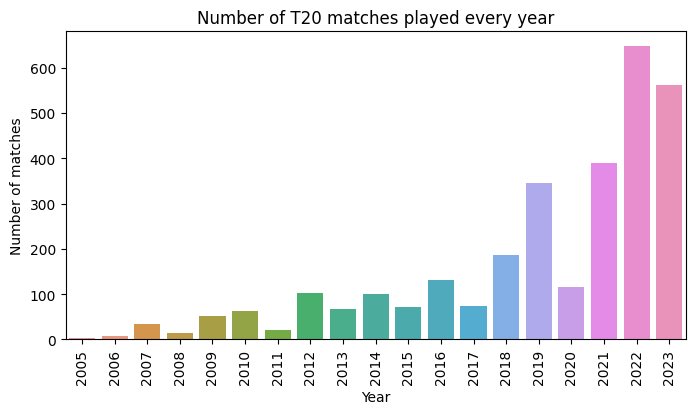

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the date column to datetime format
df_winner['date'] = pd.to_datetime(df_winner['date'])

# Extract the year from the date column
df_winner['year'] = df_winner['date'].dt.year

# Group the data by year and count the number of matches played
matches_per_year = df_winner.groupby('year')['match_id'].count()

# Plot the number of matches played every year
plt.figure(figsize=(8, 4))
sns.barplot(x=matches_per_year.index.astype(int), y=matches_per_year.values)
plt.title('Number of T20 matches played every year')
plt.xlabel('Year')
plt.ylabel('Number of matches')
plt.xticks(rotation=90)
plt.show()

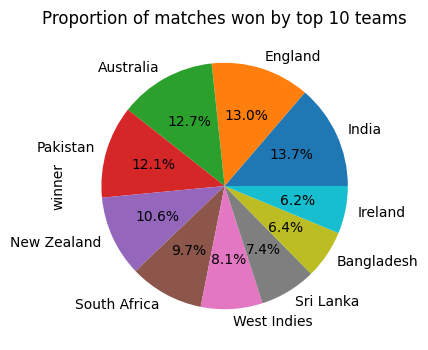

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of matches won by each team
matches_won = df_winner['winner'].value_counts()

# Calculate the win percentage for each team
win_percentages = (matches_won / matches_won.sum()) * 100

# Get the top 10 teams with the highest win percentages in descending order
top_10_teams = win_percentages.nlargest(10).sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(8, 4))
top_10_teams.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of matches won by top 10 teams')
plt.show()

In [ ]:
top_10_teams.index

Index(['India', 'England', 'Australia', 'Pakistan', 'New Zealand',
       'South Africa', 'West Indies', 'Sri Lanka', 'Bangladesh', 'Ireland'],
      dtype='object')

<Figure size 800x400 with 0 Axes>

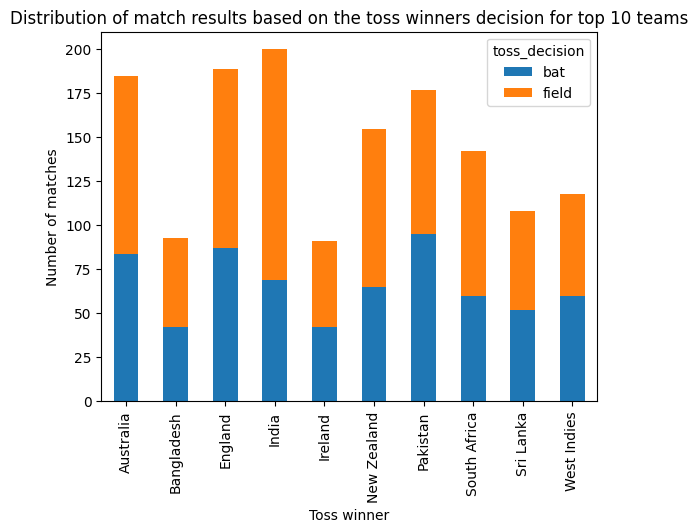

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for the top 10 teams
df_top_10_teams = df_winner[df_winner['winner'].isin(top_10_teams.index)]

# Group the data by the toss winner and toss decision columns and count the number of matches won by each team
matches_won_by_toss_decision = df_top_10_teams.groupby(['winner', 'toss_decision'])['toss_winner'].count().unstack(fill_value=0)

# Plot the stacked bar chart
plt.figure(figsize=(8, 4))
matches_won_by_toss_decision.plot(kind='bar', stacked=True)
plt.title('Distribution of match results based on the toss winners decision for top 10 teams')
plt.xlabel('Toss winner')
plt.ylabel('Number of matches')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit the encoder with the unique values across 'team_name', 'team1', and 'team2' columns
le.fit(pd.concat([df['team_name'], df['team1'], df['team2'], df['toss_winner'], df['winner']]))

# Transform 'team_name', 'team1', and 'team2' columns with the fitted encoder
df['team_name_encoded'] = le.transform(df['team_name'])
df['team1_encoded'] = le.transform(df['team1'])
df['team2_encoded'] = le.transform(df['team2'])
df['toss_winner_encoded'] = le.transform(df['toss_winner'])
df['winner_encoded'] = le.transform(df['winner'])

# Converting into Batting and Bowling Teams
df['batting_team_encoded'] = df['team_name_encoded']
df['bowling_team_encoded'] = df.apply(lambda row: row['team1_encoded'] if row['team1_encoded'] != row['batting_team_encoded'] else row['team2_encoded'], axis=1)

# For other columns, fit and transform separately
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])
df['venue_encoded'] = LabelEncoder().fit_transform(df['venue'])
df['toss_decision_encoded'] = LabelEncoder().fit_transform(df['toss_decision'])

In [ ]:
import pandas as pd

# Print the classes and corresponding labels for 'team_name', 'team1', and 'team2'
print("Mappings for 'team_name', 'team1', 'team2' and 'toss_winner':")
mapping_df = pd.DataFrame({'Class': range(len(le.classes_)), 'Label': le.classes_})
mapping_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data602_project/team_mappings.csv', index=False)
print(mapping_df)

# For other columns, create separate LabelEncoders and print their mappings
columns_to_encode = ['gender', 'venue', 'toss_decision']
for column in columns_to_encode:
    le = LabelEncoder()
    le.fit(df[column])
    print(f"\nMappings for '{column}':")
    mapping_df = pd.DataFrame({'Class': range(len(le.classes_)), 'Label': le.classes_})
    mapping_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/data602_project/{column}_mappings.csv', index=False)
    print(mapping_df)

Mappings for 'team_name', 'team1', 'team2' and 'toss_winner':
   Class  Label
0      0    bat
1      1  field

Mappings for 'gender':
   Class   Label
0      0  female
1      1    male

Mappings for 'venue':
     Class                                              Label
0        0                                        AMI Stadium
1        1                                      Adelaide Oval
2        2  Al Amerat Cricket Ground Oman Cricket (Ministr...
3        3  Al Amerat Cricket Ground Oman Cricket (Ministr...
4        4                                 Allan Border Field
..     ...                                                ...
359    359                             Yeonhui Cricket Ground
360    360                      Zahur Ahmed Chowdhury Stadium
361    361          Zahur Ahmed Chowdhury Stadium, Chattogram
362    362                   Zayed Cricket Stadium, Abu Dhabi
363    363    Zhejiang University of Technology Cricket Field

[364 rows x 2 columns]

Mappings for 'toss_deci

In [ ]:
# Creating a training dataframe which will be further used for training
final_df = df[['gender_encoded', 'inning_no', 'batting_team_encoded', 'bowling_team_encoded', 'venue_encoded', 'toss_winner_encoded', 'toss_decision_encoded', 'wickets_lost', 'crr', 'rrr', 'result']]
final_df_female = final_df[final_df['gender_encoded'] == 0]
final_df_male = final_df[final_df['gender_encoded'] == 1]
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data602_project/final_df.csv')

In [ ]:
final_df

,gender_encoded,inning_no,batting_team_encoded,bowling_team_encoded,venue_encoded,toss_winner_encoded,toss_decision_encoded,wickets_lost,crr,rrr,result
0,0,1,63,50,304,50,1,0,0.000000,0.000000,True
1,0,1,63,50,304,50,1,0,1.000000,0.000000,True
2,0,1,63,50,304,50,1,0,2.000000,0.000000,True
3,0,1,63,50,304,50,1,0,3.000000,0.000000,True
4,0,1,63,50,304,50,1,0,1.500000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
685469,0,2,86,6,77,86,1,2,1.045455,0.093750,True
685470,0,2,86,6,77,86,1,2,1.033708,0.096774,True
685471,0,2,86,6,77,86,1,2,1.033333,0.066667,True
685472,0,2,86,6,77,86,1,2,1.032967,0.034483,True


In [ ]:
final_df.describe()

,gender_encoded,inning_no,batting_team_encoded,bowling_team_encoded,venue_encoded,toss_winner_encoded,toss_decision_encoded,wickets_lost,crr,rrr
count,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000,685474.000000
mean,0.671375,1.466363,56.192849,56.263873,178.900823,55.739741,0.514711,2.687943,1.084081,0.802943
std,0.469714,0.498868,31.424303,31.391634,106.424429,31.852837,0.499784,2.279040,0.436197,2.329416
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.000000
25%,0.000000,1.000000,33.000000,33.000000,88.000000,31.000000,0.000000,1.000000,0.818182,0.000000
50%,1.000000,1.000000,64.000000,64.000000,173.000000,63.000000,1.000000,2.000000,1.071429,0.000000
75%,1.000000,2.000000,86.000000,86.000000,266.000000,86.000000,1.000000,4.000000,1.333333,1.270833
max,1.000000,2.000000,102.000000,102.000000,363.000000,102.000000,1.000000,11.000000,17.000000,270.000000


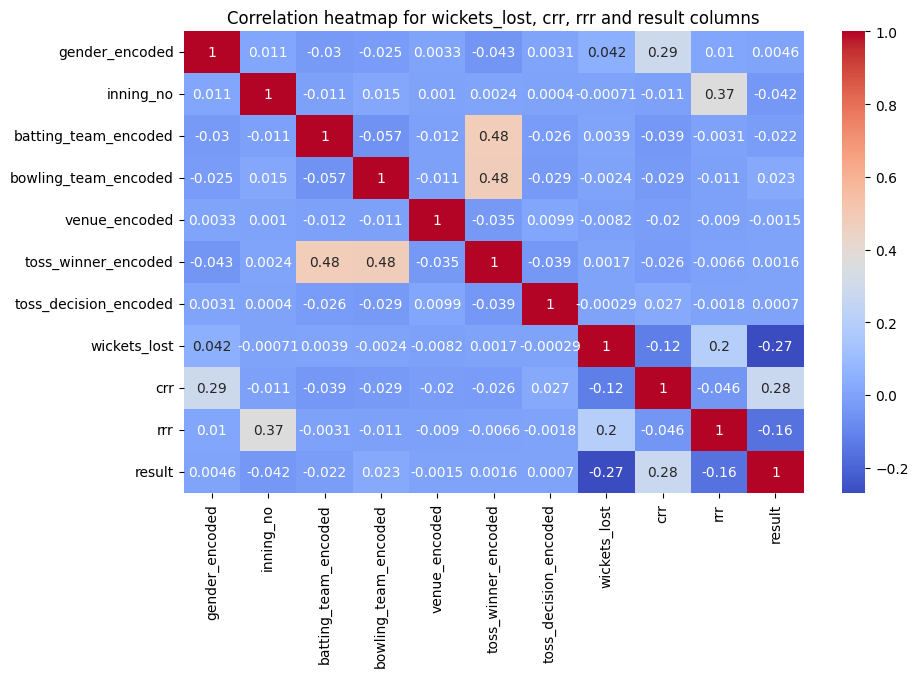

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns you want to include in the correlation heatmap
columns = ['wickets_lost', 'crr', 'rrr', 'result']

# Calculate the correlation matrix
corr_matrix = final_df[columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap for wickets_lost, crr, rrr and result columns')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your DataFrame and 'target' is your target variable
X = final_df.drop('result', axis=1)
y = final_df['result']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler with the features and transform them
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a logistic regression model
lr_model = LogisticRegression()

# Fit the model with the training data
lr_model.fit(X_train, y_train)

# Predict the target for the test data
y_pred = lr_model.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Logistic Regression Model Performance:")
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred))

Logistic Regression Model Performance:
Accuracy: 0.732105474306138
              precision    recall  f1-score   support

       False       0.74      0.74      0.74     70627
        True       0.72      0.72      0.72     66468

    accuracy                           0.73    137095
   macro avg       0.73      0.73      0.73    137095
weighted avg       0.73      0.73      0.73    137095



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your DataFrame and 'target' is your target variable
X = final_df_male.drop('result', axis=1)
y = final_df_male['result']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler with the features and transform them
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Predict the target for the test data
y_pred = model.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your DataFrame and 'target' is your target variable
X = final_df_female.drop('result', axis=1)
y = final_df_female['result']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler with the features and transform them
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Predict the target for the test data
y_pred = model.predict(X_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'target' is your target variable
X = final_df.drop('result', axis=1)
y = final_df['result']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler with the features and transform them
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=23)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Print the performance metrics for the Random Forest model
print("Random Forest Model Performance:")
print(f'Accuracy: {accuracy_score(y_test, rf_y_pred)}')
print(classification_report(y_test, rf_y_pred))

# Create an XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Print the performance metrics for the XGBoost model
print("\nXGBoost Model Performance:")
print(f'Accuracy: {accuracy_score(y_test, xgb_y_pred)}')
print(classification_report(y_test, xgb_y_pred))

Random Forest Model Performance:
Accuracy: 0.9916627156351435
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     70672
        True       0.99      0.99      0.99     66423

    accuracy                           0.99    137095
   macro avg       0.99      0.99      0.99    137095
weighted avg       0.99      0.99      0.99    137095


XGBoost Model Performance:
Accuracy: 0.9180349392756847
              precision    recall  f1-score   support

       False       0.93      0.91      0.92     70672
        True       0.91      0.92      0.92     66423

    accuracy                           0.92    137095
   macro avg       0.92      0.92      0.92    137095
weighted avg       0.92      0.92      0.92    137095



<ipython-input-88-24ac778cd498>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(columns, rotation=90)
<ipython-input-88-24ac778cd498>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(columns, rotation=90)
<ipython-input-88-24ac778cd498>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(columns, rotation=90)


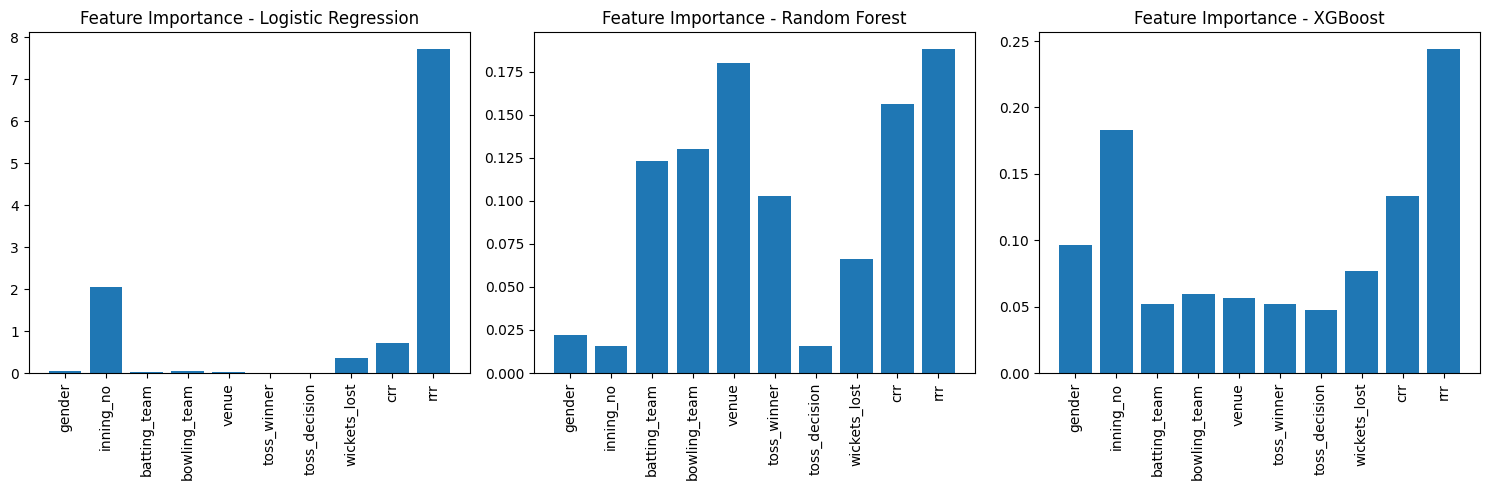

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

columns = ['gender', 'inning_no', 'batting_team', 'bowling_team', 'venue', 'toss_winner', 'toss_decision', 'wickets_lost', 'crr', 'rrr']

# Plot the feature importance for Logistic Regression
axs[0].bar(X.columns, abs(lr_model.coef_[0]))
axs[0].set_xticklabels(columns, rotation=90)
axs[0].set_title('Feature Importance - Logistic Regression')

# Plot the feature importance for Random Forest
axs[1].bar(X.columns, rf_model.feature_importances_)
axs[1].set_xticklabels(columns, rotation=90)
axs[1].set_title('Feature Importance - Random Forest')

# Plot the feature importance for XGBoost
axs[2].bar(X.columns, xgb_model.feature_importances_)
axs[2].set_xticklabels(columns, rotation=90)
axs[2].set_title('Feature Importance - XGBoost')

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
lr_model.predict_proba([[1,2,24,90,60,24,1,2,1.25,0.5]])

NameError: ignored

In [ ]:
rf_model.predict_proba([[1,2,24,90,60,24,1,2,1.25,0.5]])

In [ ]:
xgb_model.predict_proba([[1,2,24,90,60,24,1,2,1.25,0.5]])

In [ ]:
import pickle
LR_Model=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data602_project/lr_model.pkl','rb'))
RF_Model=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data602_project/rf_model.pkl','rb'))
XGB_Model=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data602_project/xgb_model.pkl','rb'))

In [ ]:
X.head()

,gender_encoded,inning_no,batting_team_encoded,bowling_team_encoded,venue_encoded,toss_winner_encoded,toss_decision_encoded,wickets_lost,crr,rrr
0,0,1,63,50,304,50,1,0,0.0,0.0
1,0,1,63,50,304,50,1,0,1.0,0.0
2,0,1,63,50,304,50,1,0,2.0,0.0
3,0,1,63,50,304,50,1,0,3.0,0.0
4,0,1,63,50,304,50,1,0,1.5,0.0


In [ ]:
inference = [[1, 2, 41, 86, 287, 86, 1, 1, 2.1842105263157, 1.3269230769230]]
scaled_inference = scaler.transform(inference)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
LR_Model.predict_proba(scaled_inference)

array([[0.14553392, 0.85446608]])

In [ ]:
RF_Model.predict_proba(scaled_inference)

array([[0.27, 0.73]])

In [ ]:
XGB_Model.predict_proba(scaled_inference)

array([[0.25158614, 0.74841386]], dtype=float32)

In [ ]:
import pickle
pickle.dump(lr_model,open('/content/drive/MyDrive/Colab Notebooks/data602_project/lr_model.pkl','wb'))
pickle.dump(rf_model,open('/content/drive/MyDrive/Colab Notebooks/data602_project/rf_model.pkl','wb'))
pickle.dump(xgb_model,open('/content/drive/MyDrive/Colab Notebooks/data602_project/xgb_model.pkl','wb'))